In [ ]:
from notebooks import *
print_sys_info()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


The potoo.default_magic_magic extension is already loaded. To reload it, use:
  %reload_ext potoo.default_magic_magic
platform:
  machine: x86_64
  node: Dan-B.local
  processor: i386
  release: 15.6.0
  system: Darwin
  version: 'Darwin Kernel Version 15.6.0: Thu Jun 23 18:25:34 PDT 2016; root:xnu-3248.60.10~1/RELEASE_X86_64'
cpu: 8
mem: 16g
swap: 20g


In [ ]:
# Load models
load = Load()
projection = Projection.load('peterson-v0-26bae1c', features=Features(load=load))

[21:11:37.462] DEBUG  Projection.load
  path: /Users/danb/hack/bubo/features/data/models/projection/peterson-v0-26bae1c.pkl


In [ ]:
# Select recs
#   1. countries: Filter recs to these countries
#   2. com_names: Filter recs to these species
#   3. recs_at_least: Filter species to those with at least this many recs
#   4. num_species: Sample this many of the species
#   5. num_recs: Sample this many recs per species
get_recs_stats = lambda df: dict(sp=df.species.nunique(), recs=len(df))
puts_stats = lambda desc: partial(tap, f=lambda df: print('%-15s %12s (sp/recs)' % (desc, '%(sp)s/%(recs)s' % get_recs_stats(df))))
countries, com_names = countries_na, com_names_ca  # 400k/9.4k -> 60k/1.1k -> 35k/334
# recs_at_least, num_species, num_recs = 100, 100, 100  # ca[334/35k -> 127/25k -> 100/21k -> 100/10k   -> 100/10k]
# recs_at_least, num_species, num_recs =  50, 100, 100  # ca[334/35k -> 224/32k -> 100/16k -> 100/ 9.0k -> 100/ 9.0k]
# recs_at_least, num_species, num_recs =   0, 100, 100  # ca[334/35k -> 334/35k -> 100/12k -> 100/ 6.8k ->  99/ 6.8k]
# recs_at_least, num_species, num_recs =   0, 168, 100  # ca[334/34k -> 334/34k -> 168/18k -> 168/11k   -> 167/11k]    # (old 'all')
# recs_at_least, num_species, num_recs =   0, 168,  20  # ca[334/34k -> 334/35k -> 168/18k -> 168/ 3.2k -> 167/ 3.2k]  # (old 'recs')
recs_at_least, num_species, num_recs =  20, 168,  20    # ca[334/35k -> 296/35k -> 168/20k -> 168/ 3.4k -> 168/ 3.4k]  # (old 'recs')
# recs_at_least, num_species, num_recs =  20, 50,  100  # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  50   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  20   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  10   # Faster dev
# recs_at_least, num_species, num_recs =  20, 50,  5    # Faster dev
xcs = (xc.metadata
    .pipe(puts_stats('all'))
    # 1. countries: Filter recs to these countries
    [lambda df: df.country.isin(countries)]
    .pipe(puts_stats('countries'))
    # 2. com_names: Filter recs to these species
    [lambda df: df.com_name.isin(com_names)]
    .pipe(puts_stats('com_names'))
    # Omit not-downloaded recs (should be few within the selected countries)
    [lambda df: df.downloaded]
    .pipe(puts_stats('(downloaded)'))
    # Remove empty cats for perf
    .pipe(df_remove_unused_categories)
    # 3. recs_at_least: Filter species to those with at least this many recs
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= recs_at_least].index)]
    .pipe(puts_stats('recs_at_least'))
    # 4. num_species: Sample this many of the species
    [lambda df: df.species.isin(df.species.drop_duplicates().pipe(lambda s: s.sample(n=min(len(s), num_species), random_state=0)))]
    .pipe(puts_stats('num_species'))
    # 5. num_recs: Sample this many recs per species
    #   - Remove empty cats else .groupby fails on empty groups
    .pipe(df_remove_unused_categories)
    .groupby('species').apply(lambda g: g.sample(n=min(len(g), num_recs), random_state=0))
    .pipe(puts_stats('num_recs'))
    # Drop species with <2 recs, else StratifiedShuffleSplit complains (e.g. 'TUVU')
    [lambda df: df.species.isin(df.species.value_counts()[lambda s: s >= 2].index)]
    .pipe(puts_stats('recs ≥ 2'))
    # Clean up for downstream
    .pipe(df_remove_unused_categories)
)
_recs_stats = get_recs_stats(xcs)
recs_stats = ', '.join(['%s[%s]' % (k, v) for k, v in _recs_stats.items()])
display(
    recs_stats,
    df_summary(xcs).T,
    xcs.sample(n=10, random_state=0).sort_values('species'),
)

all              9442/399859 (sp/recs)
countries         1148/59713 (sp/recs)
com_names          334/35236 (sp/recs)
(downloaded)       334/35232 (sp/recs)
recs_at_least      296/34846 (sp/recs)
num_species        168/19640 (sp/recs)


num_recs            168/3360 (sp/recs)
recs ≥ 2            168/3360 (sp/recs)


'sp[168], recs[3360]'

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
downloaded,bool,94080,3360,3360,1,NaN,NaN,True,True,True,True,True
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
id,int64,94080,3360,3360,3360,213283.439,108055.964,1133,138144,193564,308285,416744
sci_name,category,227200,3360,3360,168,NaN,NaN,Anser albifrons,Gelochelidon nilotica,Vireo olivaceus,Parkesia noveboracensis,Spinus tristis
com_name,category,220320,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
subspecies,object,169603,3360,3360,205,NaN,NaN,,,,,zaboria
recordist,object,211728,3360,3360,291,NaN,NaN,AJ Knue,Frank Lambert,Matthias Feuersenger,Peter Boesman,tetiaroa
country,object,203063,3360,3360,3,NaN,NaN,Canada,United States,United States,United States,United States
locality,object,316516,3360,3360,1740,NaN,NaN,"Bahía la Ventosa, Salina Cruz, Oaxaca","Desert Beeline Highway, Maricopa County, Arizona","May Lake, Yosemite NP, California","Sabine Nature Trail loop, Cameron Parish, Louisiana","west of Thorp, WA"


,,downloaded,species,id,sci_name,com_name,subspecies,recordist,country,locality,lat,lng,type,quality,date,time,license_type,license_detail,license,url,download
species,,,,,,,,,,,,,,,,,,,,,
COGA,205189,True,COGA,207451,Gallinula galeata,Common Gallinule,sandvicensis,Ross Gallardy,United States,"Kailua, Honolulu County, Hawaii",21.4,-158.0,call,B,2014-12-21 00:00:00,07:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/207451,//www.xeno-canto.org/207451/download
INDO,18832,True,INDO,398616,Columbina inca,Inca Dove,,Manuel Grosselet,Mexico,Lomas de Bezares Miguel Hidalgo Mexico city,19.4,-99.2,song,B,2018-01-07 00:00:00,08:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/398616,//www.xeno-canto.org/398616/download
EWPW,223194,True,EWPW,188611,Antrostomus vociferus,Eastern Whip-poor-will,,David Jonas Weber,United States,"Gravelly Hill Rd., Salem County, New Jersey",39.5,-75.4,song,C,2014-07-25 00:00:00,05:30,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/188611,//www.xeno-canto.org/188611/download
NUWO,113835,True,NUWO,301366,Picoides nuttallii,Nuttall's Woodpecker,,Denise Wight,United States,"Moraga, Contra Costa County, California",37.8,-122.0,"Hawk mobbing call, alarm call",C,2016-01-25 00:00:00,10:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/301366,//www.xeno-canto.org/301366/download
BBWO,80808,True,BBWO,335436,Picoides arcticus,Black-backed Woodpecker,,Lance A. M. Benner,United States,"Blackrock Trailhead, Tulare County, California",36.2,-118.0,"drumming, male",no score,2016-09-17 00:00:00,16:41,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/335436,//www.xeno-canto.org/335436/download
HUVI,117936,True,HUVI,297126,Vireo huttoni,Hutton's Vireo,,Paul Marvin,United States,"Kickapoo Cavern State Park, Brackettville, Texas",29.6,-100.0,song,C,2012-04-08 00:00:00,07:58,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/297126,//www.xeno-canto.org/297126/download
MGWA,89731,True,MGWA,326299,Geothlypis tolmiei,MacGillivray's Warbler,,Lance A. M. Benner,United States,"Buckhorn Campground, San Gabriel Mountains, Los Angeles County, California",34.3,-118.0,"male, song",no score,2016-06-28 00:00:00,10:49,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/326299,//www.xeno-canto.org/326299/download
PUFI,159786,True,PUFI,254326,Haemorhous purpureus,Purple Finch,,Iain,Canada,"Algonquin Highlands, Haliburton County, Ontario",45.3,-78.8,song,C,2015-06-27 00:00:00,11:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/254326,//www.xeno-canto.org/254326/download
CAFI,46804,True,CAFI,369971,Haemorhous cassinii,Cassin's Finch,,Eric DeFonso,United States,"Dunton Rd area, San Juan National Forest, Dolores County, Colorado",37.8,-108.0,song,A,2016-06-28 00:00:00,15:00,by-nc-sa,4.0,//creativecommons.org/licenses/by-nc-sa/4.0/,https://www.xeno-canto.org/369971,//www.xeno-canto.org/369971/download


In [ ]:
xcs_paths = [
    ('xc', f'{data_dir}/xc/data/{row.species}/{row.id}/audio.mp3')
    for row in df_rows(xcs)
]
joblib.dump(xcs_paths, '/tmp/xcs_paths')  # In case you want to run load.recs in a terminal (it's long and verbose)
display(
    len(xcs_paths),
    # xcs_paths[:2],
)

3360

In [ ]:
# TODO Restore once:true after debug [but think carefully how once:true interacts with the once:false params above]
recs = load.recs(paths=xcs_paths)
display(
    df_summary(recs).T,
    recs[:5],
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
dataset,object,171360,3360,3360,1,NaN,NaN,xc,xc,xc,xc,xc
species,category,178080,3360,3360,168,NaN,NaN,GWFG,GBTE,REVI,NOWA,AMGO
species_com_name,category,219160,3360,3360,168,NaN,NaN,Greater White-fronted Goose,Gull-billed Tern,Red-eyed Vireo,Northern Waterthrush,American Goldfinch
species_query,object,178080,3360,3360,168,NaN,NaN,ACWO,CONI,LASP,RIRA,YRWA
duration_s,float64,80640,3360,3360,3054,5.430e+01,7.031e+01,0.697,14.4,31.8,65.4,940
samples_mb,float64,80640,3360,3360,3055,2.286e+00,2.958e+00,0.0293,0.604,1.34,2.76,39.5
samples_n,int64,94080,3360,3360,3055,1.198e+06,1.551e+06,15368,316510,701190,1444435,20731931
basename,object,181440,3360,3360,1,NaN,NaN,audio,audio,audio,audio,audio
species_longhand,category,242680,3360,3360,168,NaN,NaN,Greater White-fronted Goose - GWFG,Gull-billed Tern - GBTE,Red-eyed Vireo - REVI,Northern Waterthrush - NOWA,American Goldfinch - AMGO


,dataset,species,species_com_name,species_query,duration_s,samples_mb,samples_n,basename,species_longhand,id,path
0,xc,GWFG,Greater White-fronted Goose,GWFG,23.7,0.997,522850,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/149379/audio,xc/data/GWFG/149379/audio.mp3
1,xc,GWFG,Greater White-fronted Goose,GWFG,18.3,0.770,403780,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276918/audio,xc/data/GWFG/276918/audio.mp3
2,xc,GWFG,Greater White-fronted Goose,GWFG,45.0,1.890,991296,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/210100/audio,xc/data/GWFG/210100/audio.mp3
3,xc,GWFG,Greater White-fronted Goose,GWFG,17.6,0.738,387072,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/323113/audio,xc/data/GWFG/323113/audio.mp3
4,xc,GWFG,Greater White-fronted Goose,GWFG,24.0,1.010,528142,audio,Greater White-fronted Goose - GWFG,xc/data/GWFG/276919/audio,xc/data/GWFG/276919/audio.mp3


In [ ]:
# Fast-and-cheap version (<1s) of the plot below (7s)
(recs
    .species_longhand.value_counts().sort_index()
    .reset_index().rename(columns={'index': 'species_longhand', 'species_longhand': 'num_recs'})
    .assign(num_recs=lambda df: df.num_recs.map(lambda n: '%s /%s' % ('•' * int(n / df.num_recs.max() * 60), df.num_recs.max())))
)

,species_longhand,num_recs
0,Greater White-fronted Goose - GWFG,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
1,Gadwall - GADW,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
2,American Wigeon - AMWI,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
3,Mallard - MALL,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
4,Green-winged Teal - GWTE,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
5,California Quail - CAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
6,Gambel's Quail - GAQU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
7,Sooty Grouse - SOGR,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
8,Wild Turkey - WITU,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20
9,Common Loon - COLO,•••••••••••••••••••••••••••••••••••••••••••••••••••••••••••• /20


In [ ]:
(recs
    .assign(species=lambda df: df.species_longhand)
    .assign(count=1)
    # 0-fill all (species, dataset) combinations to create empty placeholders for missing bars
    .pipe(lambda df: df.append(
        pd.DataFrame([
            dict(species=species, dataset=dataset, duration_s=0)
            for species in df.species.unique()
            for dataset in df.dataset.unique()
        ])
        .astype({'species': df.species.dtype})
    ))
    .groupby(['dataset', 'species'])[['count', 'duration_s']].sum().reset_index()
    # Order by species by taxo
    .pipe(df_reverse_cat, 'species')
    # Order by species by count
    # .pipe(df_ordered_cat, species=lambda df: df.sort_values('count').species)
    .pipe(pd.melt, id_vars=['dataset', 'species'], value_vars=['count', 'duration_s'])
    .pipe(df_remove_unused_categories)
    .pipe(ggplot, aes(x='species', y='value', fill='dataset', color='dataset'))
    + coord_flip()
    + geom_bar(stat='identity', position=position_dodge(), width=.8)
    + facet_wrap('variable', nrow=1, scales='free')
    + xlab('')
    + ylab('')
    + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab10)
    + theme(panel_spacing=2.5)
    + theme_figsize(width=18, aspect_ratio=4/1)
    + ggtitle(f'recs: Total (count, duration_s) per (species, dataset)')
)

[skip]

In [ ]:
# Add .feat
recs = projection.transform(recs)

In [ ]:
# GridSearchCV many models / model params
#   - Order these roughly from most to least expensive, so that training runs fail fast (e.g. oom at the start, not the end)
param_grid = [
    dict(
        classifier=[

            # RandomForest(entropy)
            #   - 'gini' tends has better accuracy
            # 'cls: rf, criterion: entropy, n_estimators: 200',  # [SP14]

            # RandomForest(gini)
            #
            # WARNING These two are not very mem safe...
            #   - They finish, but they cause OSX to "Not responding" most/all of its apps at ~2-3 different times
            # 'cls: rf, criterion: gini, n_estimators: 2000',
            # 'cls: rf, criterion: gini, n_estimators: 1500',
            #
            # 'cls: rf, criterion: gini, n_estimators: 1000',
            # 'cls: rf, criterion: gini, n_estimators: 800',
            # 'cls: rf, criterion: gini, n_estimators: 600',
            # 'cls: rf, criterion: gini, n_estimators: 400',
            # f'cls: rf, criterion: gini, n_estimators: 200, max_depth: {max_depth}',
            # f'cls: rf, criterion: gini, n_estimators: 100, max_depth: {max_depth}',
            # 'cls: rf, criterion: gini, n_estimators: 50',
            # 'cls: rf, criterion: gini, n_estimators: 10',
            # 'cls: rf, criterion: gini, n_estimators: 1',

            f'cls: rf, criterion: gini, n_estimators: 100, max_depth: {max_depth}',
            f'cls: rf, criterion: gini, n_estimators: 20, multiclass: ovr, max_depth: {
                max_depth if max_depth == "null" else max_depth / 10
            }',

        ],
        n_species=[n_species if isinstance(n_species, int) else int(n_species * _recs_stats['sp'])],
        n_recs=[
            # n_recs if isinstance(n_recs, int) else int(n_recs * _recs_stats['recs']),
            # TODO Figure out how to represent this as an n instead of a frac again [TODO interaction with test_size=.2 ...]
            #   - TODO Also make clear in the plot descs when e.g. (recs[3360], n_species[33], n_recs[1.0]) -> n_recs[33*20 < 3360]
            n_recs,
        ],
    )
    for (n_species, n_recs) in [
        # Subset for learning curves
        #   - Biggest first, to fail fast

        # (None, None),

        (1.00, 1.00),
        (1.00, 0.50),
        # (0.75, 1.00),
        # (0.75, 0.50),
        (0.50, 1.00),
        # (0.50, 0.50),
        # (0.25, 1.00),
        # (0.25, 0.50),

        # (1.00, 1.00),
        # (1.00, 0.80),
        # (1.00, 0.60),
        # (1.00, 0.40),
        # (1.00, 0.20),

    ]
    # TODO TODO model_size ~ forest_depth
    for mean_depth_at_168_sp in [93.5]
    for max_depth in [
        'null',
        int(mean_depth_at_168_sp * n_species * 1),
        int(mean_depth_at_168_sp * n_species * 3/4),
        int(mean_depth_at_168_sp * n_species * 1/2),
        int(mean_depth_at_168_sp * n_species * 1/3),
        int(mean_depth_at_168_sp * n_species * 1/4),
        int(mean_depth_at_168_sp * n_species * 1/8),
        # int(mean_depth_at_168_sp * n_species * 1/16),
    ]
]

# TODO Increase cv to decrease variance in eval metrics (this made Alex extremely squirmy)
cv = GridSearchCVCached(
    estimator=Search(projection=projection),
    param_grid=param_grid,
    refit=False,  # Don't spend time fitting cv.best_estimator_ at the end (default: True)
    # cv=3,  # [SP14] uses two-/three-fold CV [why?]
    # Stratified ensures that all classes have >0 instances in each split, which is statistically maybe fishy but avoids
    # breaking various code that merges the split results back together and assumes all splits' classes are the same
    cv=sk.model_selection.StratifiedShuffleSplit(
        # n_splits=1,  # [for ~18/20 miss: ~19m, ~16g disk cache]
        # n_splits=2,
        n_splits=3,
        # n_splits=5,
        # n_splits=10,
        # n_splits=20,  # Known good [>51m uncached, >25g disk cache]
        # n_splits=100,  # [?m runtime, ?g disk cache]
        test_size=.2,
        random_state=0,
    ),
    return_train_score=True,
    extra_metrics=dict(
        # [How to specify SearchEvals here without creating caching headaches?]
        #   - e.g. defs don't bust cache on code edit
        #   - And avoid thrashing cache every time we refactor SearchEvals
        classes='estimator.classes_',
        train_i='train',
        train_y='y_train',
        train_predict_proba='estimator.classifier_.predict_proba(X_train)',
        test_i='test',
        test_y='y_test',
        test_predict_proba='estimator.classifier_.predict_proba(X_test)',
        model_size='len(joblib_dumps(estimator))',
        model_stats='model_stats(estimator)',
        proc_stats='proc_stats',
    ),
    # return_estimator=True,  # Verrrry heavy, use extra_metrics instead
    # verbose=100,
    # verbose=10,  # O(models * n_splits) lines of outputs
    verbose=1,  # O(1) lines of outputs
    # Use n_jobs=1
    #   - All classifiers can parallelize .fit/.predict
    #   - Avoid memory contention
    # n_jobs=1,  # Required for %prun
    n_jobs=8,  # HACK for slow ovr serdes
    artifacts=dict(
        dir=f'{data_dir}/artifacts',  # TODO Iron out syncing across local/gs/remote
        extra=dict(estimator='estimator'),
        save=True,
        reuse='20180709-211727-fd34af5-ovr_try_2',
    ),
)
with contextlib.ExitStack() as stack:
    # stack.enter_context(cache_control(refresh=True))  # Disk unsafe...
    stack.enter_context(cache_control(enabled=False))  # Disk safe
    # stack.enter_context(joblib.parallel_backend('threading'))  # Default: 'multiprocessing'
    # stack.enter_context(joblib.parallel_backend('sequential'))  # For %prun [FIXME Has no effect; why?]
    stack.enter_context(log.context(level='info'))
    # stack.enter_context(log.context(level='debug'))
    X, y = Search.Xy(recs)
    cv.fit(X, y)

Fitting 3 folds for each of 42 candidates, totalling 126 fits
[00:37:43.770] INFO   artifacts
  dir: /Users/danb/hack/bubo/features/data/artifacts
  extra: {estimator: estimator}
  save: true
  reuse: 20180709-211727-fd34af5-ovr_try_2
  experiment_id: 20180709-211727-fd34af5-ovr_try_2


[00:37:44.135] INFO   _fit_and_score[1/126].reuse.ret[0.033s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:44.138] INFO   _fit_and_score[2/126].reuse.ret[0.026s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:44.157] INFO   _fit_and_score[3/126].reuse.ret[0.026s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:44.244] INFO   _fit_and_score[4/126].reuse.ret[0.066s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:44.271] INFO   _fit_and_score[5/126].reuse.ret[0.066s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:44.300] INFO   _fit_and_score[6/126].reuse.ret[0.063s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:44.301] INFO   _fit_and_score[7/126].reuse.ret[0.032s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:44.332] INFO   _fit_and_score[8/126].reuse.ret[0.028s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:44.356] INFO   _fit_and_score[9/126].reuse.ret[0.019s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:44.424] INFO   _fit_and_score[10/126].reuse.ret[0.043s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:44.503] INFO   _fit_and_score[11/126].reuse.ret[0.038s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:44.587] INFO   _fit_and_score[12/126].reuse.ret[0.032s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:44.659] INFO   _fit_and_score[13/126].reuse.ret[0.014s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:44.732] INFO   _fit_and_score[14/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:44.809] INFO   _fit_and_score[15/126].reuse.ret[0.012s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:44.887] INFO   _fit_and_score[16/126].reuse.ret[0.014s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:44.952] INFO   _fit_and_score[17/126].reuse.ret[0.015s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:45.030] INFO   _fit_and_score[18/126].reuse.ret[0.019s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:45.123] INFO   _fit_and_score[19/126].reuse.ret[0.019s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:45.186] INFO   _fit_and_score[20/126].reuse.ret[0.016s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:45.254] INFO   _fit_and_score[21/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:45.331] INFO   _fit_and_score[22/126].reuse.ret[0.026s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:45.401] INFO   _fit_and_score[23/126].reuse.ret[0.024s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:45.474] INFO   _fit_and_score[24/126].reuse.ret[0.028s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:45.538] INFO   _fit_and_score[25/126].reuse.ret[0.015s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:45.608] INFO   _fit_and_score[26/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:45.675] INFO   _fit_and_score[27/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:45.752] INFO   _fit_and_score[28/126].reuse.ret[0.022s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:45.818] INFO   _fit_and_score[29/126].reuse.ret[0.023s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:45.895] INFO   _fit_and_score[30/126].reuse.ret[0.021s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:45.973] INFO   _fit_and_score[31/126].reuse.ret[0.014s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:46.032] INFO   _fit_and_score[32/126].reuse.ret[0.015s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:46.104] INFO   _fit_and_score[33/126].reuse.ret[0.011s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:46.183] INFO   _fit_and_score[34/126].reuse.ret[0.021s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:46.251] INFO   _fit_and_score[35/126].reuse.ret[0.023s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:46.320] INFO   _fit_and_score[36/126].reuse.ret[0.024s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:46.392] INFO   _fit_and_score[37/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:46.449] INFO   _fit_and_score[38/126].reuse.ret[0.008s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:46.507] INFO   _fit_and_score[39/126].reuse.ret[0.009s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:46.575] INFO   _fit_and_score[40/126].reuse.ret[0.018s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:46.638] INFO   _fit_and_score[41/126].reuse.ret[0.018s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:46.692] INFO   _fit_and_score[42/126].reuse.ret[0.016s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:46.759] INFO   _fit_and_score[43/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:46.829] INFO   _fit_and_score[44/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    2.7s


[00:37:46.898] INFO   _fit_and_score[45/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:46.981] INFO   _fit_and_score[46/126].reuse.ret[0.017s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:47.043] INFO   _fit_and_score[47/126].reuse.ret[0.019s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:47.110] INFO   _fit_and_score[48/126].reuse.ret[0.020s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:47.161] INFO   _fit_and_score[49/126].reuse.ret[0.011s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:47.229] INFO   _fit_and_score[50/126].reuse.ret[0.011s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:47.282] INFO   _fit_and_score[51/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=93',random_state=0)/ret.pkl


[00:37:47.381] INFO   _fit_and_score[52/126].reuse.ret[0.023s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:47.455] INFO   _fit_and_score[53/126].reuse.ret[0.017s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:47.517] INFO   _fit_and_score[54/126].reuse.ret[0.018s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=9.3',random_state=0)/ret.pkl


[00:37:47.602] INFO   _fit_and_score[55/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:47.673] INFO   _fit_and_score[56/126].reuse.ret[0.008s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:47.725] INFO   _fit_and_score[57/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=70',random_state=0)/ret.pkl


[00:37:47.789] INFO   _fit_and_score[58/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:47.856] INFO   _fit_and_score[59/126].reuse.ret[0.016s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:47.912] INFO   _fit_and_score[60/126].reuse.ret[0.015s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=7.0',random_state=0)/ret.pkl


[00:37:47.970] INFO   _fit_and_score[61/126].reuse.ret[0.012s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:48.048] INFO   _fit_and_score[62/126].reuse.ret[0.013s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:48.113] INFO   _fit_and_score[63/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:48.181] INFO   _fit_and_score[64/126].reuse.ret[0.013s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:48.231] INFO   _fit_and_score[65/126].reuse.ret[0.018s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:48.294] INFO   _fit_and_score[66/126].reuse.ret[0.014s, 5.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:48.352] INFO   _fit_and_score[67/126].reuse.ret[0.012s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:48.417] INFO   _fit_and_score[68/126].reuse.ret[0.014s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:48.491] INFO   _fit_and_score[69/126].reuse.ret[0.011s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=31',random_state=0)/ret.pkl


[00:37:48.570] INFO   _fit_and_score[70/126].reuse.ret[0.015s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:48.623] INFO   _fit_and_score[71/126].reuse.ret[0.014s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:48.707] INFO   _fit_and_score[72/126].reuse.ret[0.014s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.1',random_state=0)/ret.pkl


[00:37:48.775] INFO   _fit_and_score[73/126].reuse.ret[0.010s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:48.835] INFO   _fit_and_score[74/126].reuse.ret[0.011s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:48.907] INFO   _fit_and_score[75/126].reuse.ret[0.009s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:48.976] INFO   _fit_and_score[76/126].reuse.ret[0.013s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:49.048] INFO   _fit_and_score[77/126].reuse.ret[0.016s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:49.132] INFO   _fit_and_score[78/126].reuse.ret[0.016s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:49.203] INFO   _fit_and_score[79/126].reuse.ret[0.006s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:49.274] INFO   _fit_and_score[80/126].reuse.ret[0.008s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:49.358] INFO   _fit_and_score[81/126].reuse.ret[0.009s, 4.6 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:49.426] INFO   _fit_and_score[82/126].reuse.ret[0.014s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:49.491] INFO   _fit_and_score[83/126].reuse.ret[0.018s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:49.553] INFO   _fit_and_score[84/126].reuse.ret[0.013s, 5.5 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=168,n_recs=0.5,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:49.621] INFO   _fit_and_score[85/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:49.709] INFO   _fit_and_score[86/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:49.758] INFO   _fit_and_score[87/126].reuse.ret[0.007s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=null',random_state=0)/ret.pkl


[00:37:49.822] INFO   _fit_and_score[88/126].reuse.ret[0.009s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:49.886] INFO   _fit_and_score[89/126].reuse.ret[0.013s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:49.946] INFO   _fit_and_score[90/126].reuse.ret[0.013s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=null',random_state=0)/ret.pkl


[00:37:50.012] INFO   _fit_and_score[91/126].reuse.ret[0.009s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:50.080] INFO   _fit_and_score[92/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:50.127] INFO   _fit_and_score[93/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=46',random_state=0)/ret.pkl


[00:37:50.162] INFO   _fit_and_score[94/126].reuse.ret[0.013s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:50.203] INFO   _fit_and_score[95/126].reuse.ret[0.012s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:50.260] INFO   _fit_and_score[96/126].reuse.ret[0.014s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=4.6',random_state=0)/ret.pkl


[00:37:50.300] INFO   _fit_and_score[97/126].reuse.ret[0.007s, 2.3 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=35',random_state=0)/ret.pkl


[00:37:50.357] INFO   _fit_and_score[98/126].reuse.ret[0.009s, 2.3 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=35',random_state=0)/ret.pkl


[00:37:50.402] INFO   _fit_and_score[99/126].reuse.ret[0.007s, 2.3 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=35',random_state=0)/ret.pkl


[00:37:50.444] INFO   _fit_and_score[100/126].reuse.ret[0.010s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.5',random_state=0)/ret.pkl


[00:37:50.484] INFO   _fit_and_score[101/126].reuse.ret[0.011s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.5',random_state=0)/ret.pkl


[00:37:50.515] INFO   _fit_and_score[102/126].reuse.ret[0.009s, 2.3 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=3.5',random_state=0)/ret.pkl


[00:37:50.554] INFO   _fit_and_score[103/126].reuse.ret[0.005s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:50.597] INFO   _fit_and_score[104/126].reuse.ret[0.010s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:50.630] INFO   _fit_and_score[105/126].reuse.ret[0.007s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=23',random_state=0)/ret.pkl


[00:37:50.684] INFO   _fit_and_score[106/126].reuse.ret[0.012s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:50.723] INFO   _fit_and_score[107/126].reuse.ret[0.013s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:50.778] INFO   _fit_and_score[108/126].reuse.ret[0.014s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=2.3',random_state=0)/ret.pkl


[00:37:50.812] INFO   _fit_and_score[109/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=15',random_state=0)/ret.pkl


[00:37:50.846] INFO   _fit_and_score[110/126].reuse.ret[0.009s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=15',random_state=0)/ret.pkl


[00:37:50.891] INFO   _fit_and_score[111/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=15',random_state=0)/ret.pkl


[00:37:50.942] INFO   _fit_and_score[112/126].reuse.ret[0.011s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.5',random_state=0)/ret.pkl


[00:37:50.982] INFO   _fit_and_score[113/126].reuse.ret[0.014s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.5',random_state=0)/ret.pkl


[00:37:51.015] INFO   _fit_and_score[114/126].reuse.ret[0.012s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.5',random_state=0)/ret.pkl


[00:37:51.064] INFO   _fit_and_score[115/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:51.128] INFO   _fit_and_score[116/126].reuse.ret[0.008s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:51.159] INFO   _fit_and_score[117/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=11',random_state=0)/ret.pkl


[00:37:51.195] INFO   _fit_and_score[118/126].reuse.ret[0.010s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:51.228] INFO   _fit_and_score[119/126].reuse.ret[0.011s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:51.262] INFO   _fit_and_score[120/126].reuse.ret[0.011s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=1.1',random_state=0)/ret.pkl


[00:37:51.295] INFO   _fit_and_score[121/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=5',random_state=0)/ret.pkl


[00:37:51.335] INFO   _fit_and_score[122/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=5',random_state=0)/ret.pkl


[00:37:51.369] INFO   _fit_and_score[123/126].reuse.ret[0.006s, 2.4 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=100,max_depth=5',random_state=0)/ret.pkl


[00:37:51.403] INFO   _fit_and_score[124/126].reuse.ret[0.009s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=0,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=0.5',random_state=0)/ret.pkl


[00:37:51.436] INFO   _fit_and_score[125/126].reuse.ret[0.009s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=1,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=0.5',random_state=0)/ret.pkl


[00:37:51.470] INFO   _fit_and_score[126/126].reuse.ret[0.008s, 2.8 MB]: 20180709-211727-fd34af5-ovr_try_2/split_i=2,train=2688,test=672,classes=168,estimator=Search(n_species=84,n_recs=1.0,classifier='cls=rf,criterion=gini,n_estimators=20,multiclass=ovr,max_depth=0.5',random_state=0)/ret.pkl


[Parallel(n_jobs=8)]: Done 126 out of 126 | elapsed:    7.7s finished
/Users/danb/hack/bubo/features/sk_hack.py:415: RuntimeWarning: invalid value encountered in subtract
  array_means[:, np.newaxis]) ** 2,


In [ ]:
# Precompute eval metrics + dims for the plots below
#   - Grain: models
#   - Metrics: train_score, test_score, ...
#   - Dims: model_id, params_no_ns, fold, ...
ns = [
    'n_species',
    'n_recs',
    'c_n_estimators',  # Pivot plots for model_size ~ max_depth
]
cv_models = (cv_results_splits_df(cv.cv_results_)
    # Slow yaml parsing, compute up front
    .assign(params_dict=lambda df: df.apply(axis=1, func=lambda row: dict(
        **{strip_startswith(k, 'param_'): row[k] for k in df if k.startswith('param_') and k not in ['param_classifier']},
        # HACK 'classifier.foo' -> 'c_foo'
        #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
        **{'c_' + k: v for k, v in yaml.safe_load('{%s}' % row.param_classifier).items()},
        # 'classifier': yaml.safe_load('{%s}' % row.param_classifier),
    )))
    [lambda df: [c for c in df if not c.startswith('param_')]]
    # Dims from params
    .assign(
        # Useful for validation curves (vary params by classifier type)
        # params_no_ns=lambda df: df.params_dict.str['classifier'].apply(lambda x: (
        #     '%s-%s' % (x['cls'], x['criterion']) if x['cls'] == 'rf' else
        #     x['cls']
        # )),
        # Useful for learning curves (vary n_species/n_recs per classifier)
        params_no_ns=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in d if k not in ns
        )),
        ns=lambda df: df.params_dict.apply(lambda d: ', '.join(
            '%s[%s]' % (k, d[k]) for k in ns
        )),
    )
    # HACK Convert yaml strs ('x: y') to bracket style ('x[y]'), for visual consistency
    #   - TODO Refactor Search.classifier to get rid of the yaml strs ('c_cls', 'c_n_estimators', ...)
    .applymap(lambda x: x if not isinstance(x, str) else (
        re.sub(r'([^][:, ]+):\s+([^][:,]+)(, )?', r'c_\1[\2]\3',
            re.sub(r'classifier\[([^]]+)\]', r'\1',
                x,
            ),
        )
    ))
    #   - Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
        params_no_ns=lambda df: df.params_no_ns.unique(),
        ns=lambda df: df.ns.unique(),
    )
    # .eval
    .assign(
        train_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('train_i'),
            y=df.pop('train_y'),
            classes=df['classes'],
            y_scores=df.pop('train_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        test_evals=lambda df: np.vectorize(SearchEvals)(
            i=df.pop('test_i'),
            y=df.pop('test_y'),
            classes=df['classes'],
            y_scores=df.pop('test_predict_proba'),
            drop_missing_classes_for_n_species=True,  # HACK Migrate to sk Pipeline to avoid this
        ),
        # HACK Recompute (train_score, test_score) using SearchEvals.score so it can drop_missing_classes_for_n_species
        #   - Else you'll get scores that are too low (bad) because they include some -np.inf's in the median
        train_score=lambda df: df.train_evals.map(lambda x: x.score()),
        test_score=lambda df: df.test_evals.map(lambda x: x.score()),
    )
    .drop(columns=[
        'classes',
    ])
    # proc_stats
    .assign(
        mem_rss_spread=lambda df: df.proc_stats.map(lambda p: p.df.mem_rss.pipe(lambda s: s.max() - s.min())),
        mem_vms_spread=lambda df: df.proc_stats.map(lambda p: p.df.mem_vms.pipe(lambda s: s.max() - s.min())),
    )
    # Reorder
    .pipe(df_reorder_cols,
        first=['model_id', 'params', 'params_dict', 'params_no_ns', 'ns'],
        last=['train_evals', 'test_evals', 'proc_stats', 'model_stats', 'model'],
    )
    .pipe(tap, f=lambda df: display(
        df_summary(df).T,
        # df[:5],
        df,
    ))
)

,,,,,,,,min,25%,50%,75%,max
,dtype,sizeof,len,count,nunique,mean,std,,,,,
model_id,category,20457,126,126,126.0,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[0]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[23], fold[1]","n_species[168], n_recs[0.5], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[46], fold[2]","n_species[84], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[4.6], fold[0]","n_species[84], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[0.5], fold[2]"
params,category,19323,126,126,42.0,NaN,NaN,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[23]","n_species[168], n_recs[0.5], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[46]","n_species[84], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[4.6]","n_species[84], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[0.5]"
params_dict,object,46368,126,126,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
params_no_ns,category,13128,126,126,20.0,NaN,NaN,"c_cls[rf], c_criterion[gini], c_max_depth[None]","c_cls[rf], c_criterion[gini], c_max_depth[70]","c_cls[rf], c_criterion[gini], c_max_depth[31]","c_cls[rf], c_criterion[gini], c_max_depth[11]","c_cls[rf], c_criterion[gini], c_multiclass[ovr], c_max_depth[0.5]"
ns,category,12117,126,126,6.0,NaN,NaN,"n_species[168], n_recs[1.0], c_n_estimators[100]","n_species[168], n_recs[1.0], c_n_estimators[20]","n_species[168], n_recs[0.5], c_n_estimators[100]","n_species[84], n_recs[1.0], c_n_estimators[100]","n_species[84], n_recs[1.0], c_n_estimators[20]"
fold,int64,3360,126,126,3.0,1.000e+00,8.198e-01,0,0,1,2,2
train_score,float64,3024,126,126,6.0,-2.262e+00,6.394e+00,-43,-1,-1,-1,-1
test_score,float64,3024,126,126,42.0,-2.804e+01,4.424e+01,-168,-22,-14,-9,-4
fit_time,float64,3024,126,126,126.0,3.517e+01,3.949e+01,1.09,10.7,21,47.2,182


,model_id,params,params_dict,params_no_ns,ns,fold,train_score,test_score,fit_time,score_time,model_size,mem_rss_spread,mem_vms_spread,train_evals,test_evals,proc_stats,model_stats,model
0,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[0]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'rf', 'c_criterion': 'gini', 'c_n_estimators': 100, 'c_max_depth': None}","c_cls[rf], c_criterion[gini], c_max_depth[None]","n_species[168], n_recs[1.0], c_n_estimators[100]",0,-1.0,-10.0,87.00,1.600,357092405,716984320,667213824,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[94])",type n_trees tree_i leaf_count fork_count depth max_depth node_count capacity max_n_classes n_features n_outputs\n0 search/forest/tree 1...,NaN
1,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[1]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'rf', 'c_criterion': 'gini', 'c_n_estimators': 100, 'c_max_depth': None}","c_cls[rf], c_criterion[gini], c_max_depth[None]","n_species[168], n_recs[1.0], c_n_estimators[100]",1,-1.0,-10.5,87.00,1.560,356456805,716087296,647254016,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[94])",type n_trees tree_i leaf_count fork_count depth max_depth node_count capacity max_n_classes n_features n_outputs\n0 search/forest/tree 1...,NaN
2,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[2]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'rf', 'c_criterion': 'gini', 'c_n_estimators': 100, 'c_max_depth': None}","c_cls[rf], c_criterion[gini], c_max_depth[None]","n_species[168], n_recs[1.0], c_n_estimators[100]",2,-1.0,-8.0,88.20,1.710,357761605,717230080,708104192,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[96])",type n_trees tree_i leaf_count fork_count depth max_depth node_count capacity max_n_classes n_features n_outputs\n0 search/forest/tree 1...,NaN
3,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null], fold[0]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'rf', 'c_criterion': 'gini', 'c_n_estimators': 20, 'c_multiclass': 'ovr', 'c_max_depth': None}","c_cls[rf], c_criterion[gini], c_multiclass[ovr], c_max_depth[None]","n_species[168], n_recs[1.0], c_n_estimators[20]",0,-1.0,-168.0,181.00,32.700,25849619,157704192,153829376,"SearchEvals(i[(2688,)], y[(2688,)], classes[(168,)], y_scores[(2688, 168)])","SearchEvals(i[(672,)], y[(672,)], classes[(168,)], y_scores[(672, 168)])","ProcStats(interval=1.0, stats[249])",type n_classes class_ n_trees tree_i leaf_count fork_count depth max_depth node_count capacity max_n_classes n_features n_outputs\n0 ...,NaN
4,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null], fold[1]","n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null]","{'n_recs': 1.0, 'n_species': 168, 'c_cls': 'rf', 'c_criterion': 'gini', 'c_n_estimators': 20, 'c_multiclass': 'ovr', 'c_max_depth': None}","c_cls[rf], c_criterion[gini], c_multiclass[ovr], c_max_depth[None]","n_spec

In [ ]:
cv_models_proc_stats = (cv_models
    # Enable these as needed (at the cost of mem usage)
    [[
        'model_id',
        'params',
        # 'params_dict',
        'params_no_ns',
        'ns',
        'fold',
        # 'train_score',
        # 'test_score',
        # 'fit_time',
        # 'score_time',
        'mem_rss_spread',
        # 'mem_vms_spread',
        # 'train_evals',
        # 'test_evals',
        'proc_stats',
    ]]
    .pipe(df_flatmap, lambda row: [
        row.append(pd.Series(dict(**stats)))
        for stats in row.proc_stats.stats
    ])
    # Restore the cats we just destroyed [copied from cv_results_splits_df]
    .pipe(df_ordered_cat,
        model_id=lambda df: df.model_id.unique(),
        params=lambda df: df.params.unique(),
    )
    .assign(
        cpu_user=lambda df: df.cpu_user.diff() * 100,
        cpu_system=lambda df: df.cpu_system.diff() * 100,
    )
    .pipe(tap, f=lambda df: display(
        # df_summary(df).T,
        # df[:5],
    ))
)

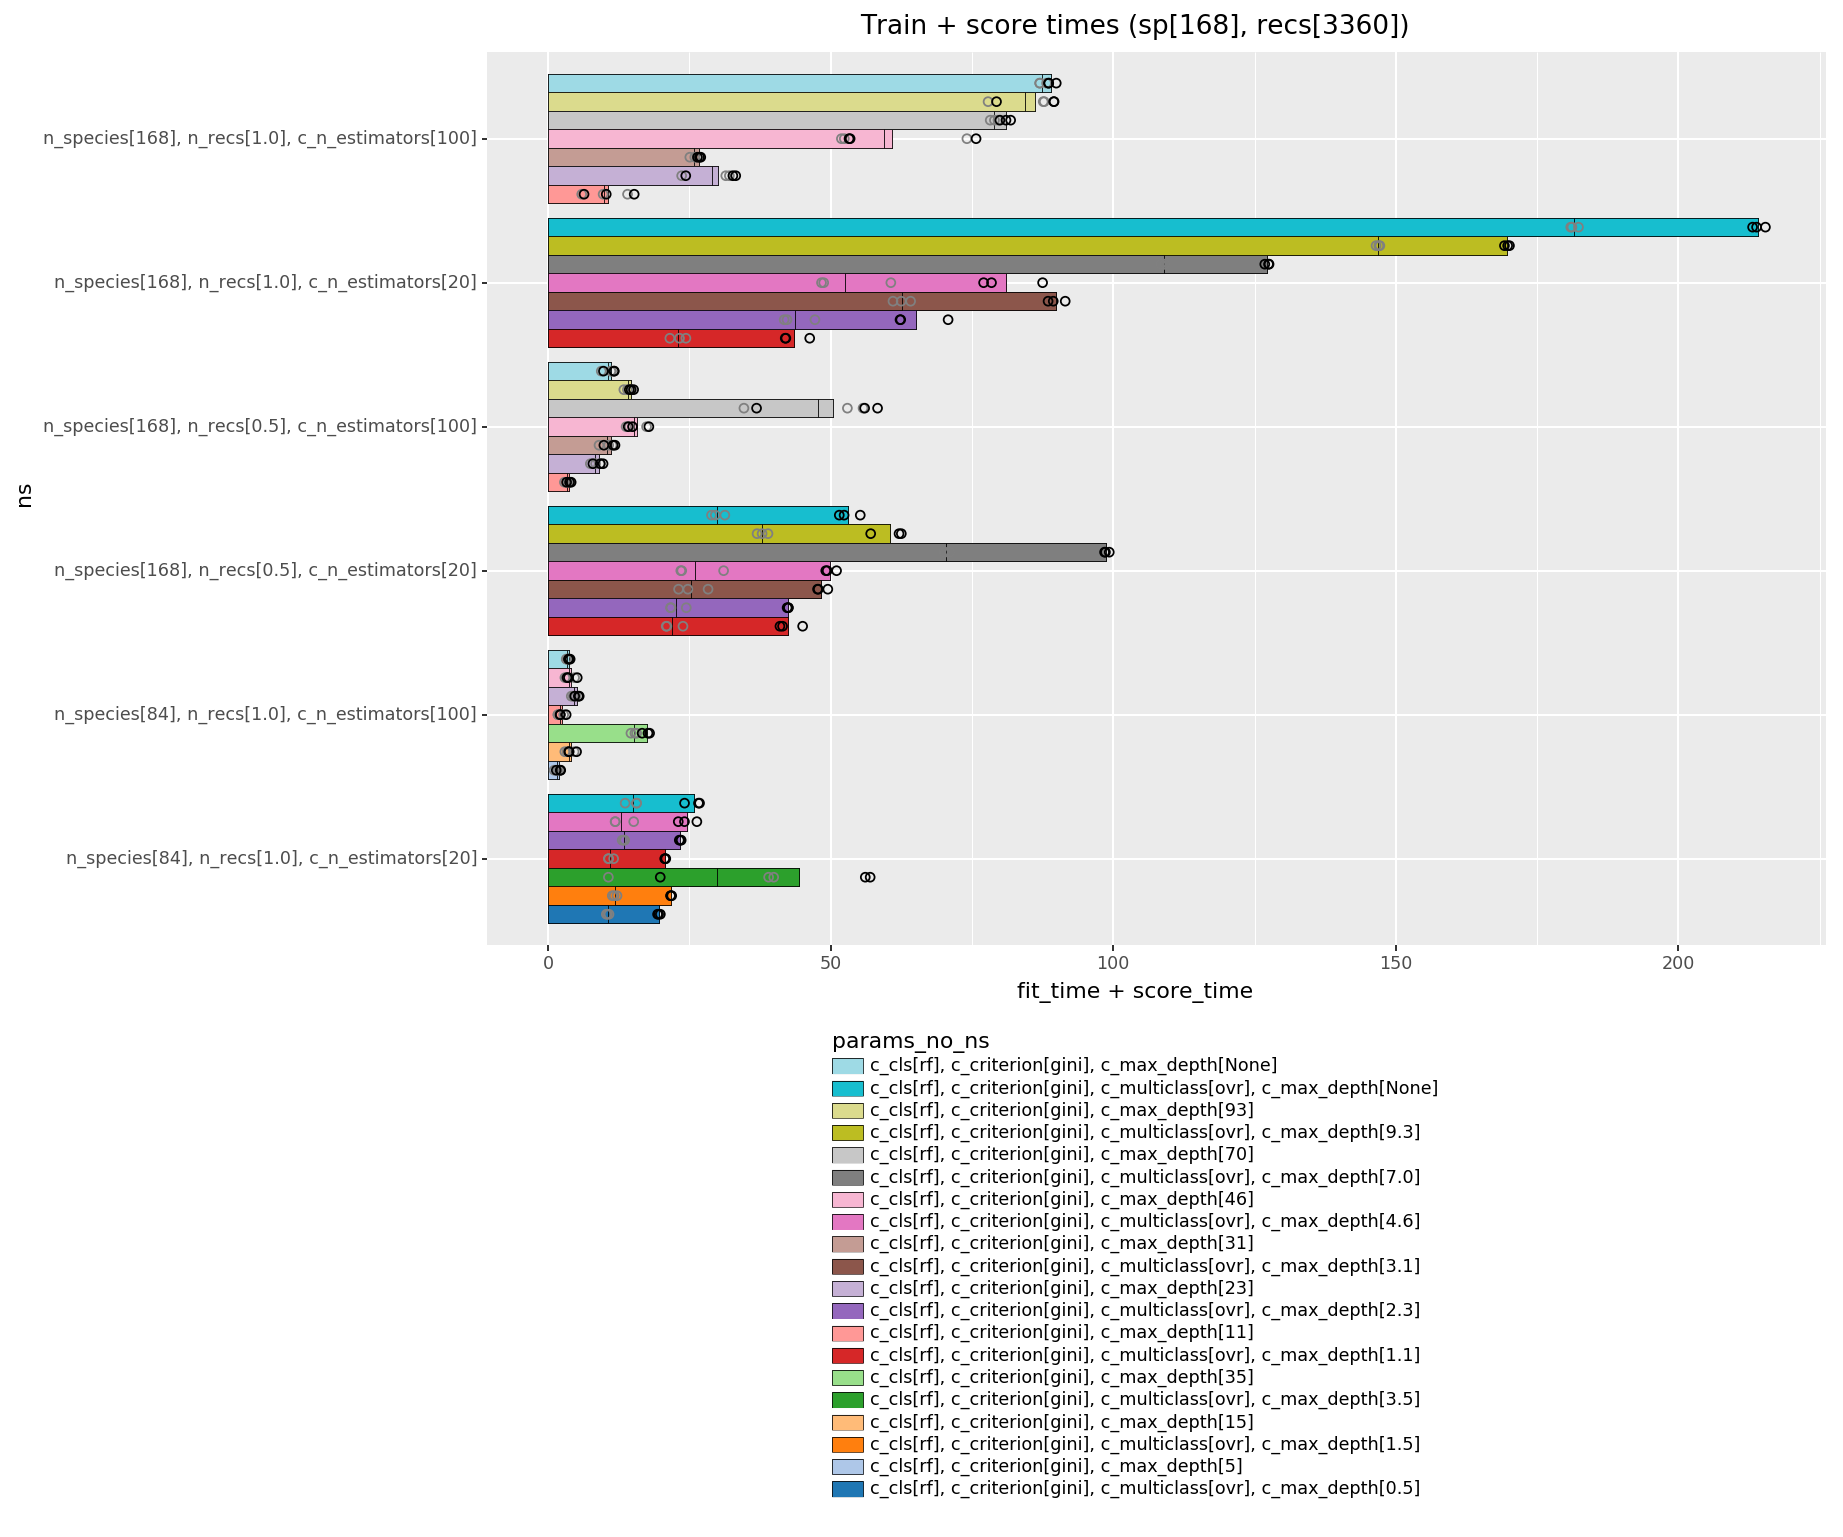

<ggplot: (338463296)>

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(
        fit_time_mean=lambda df: df.fit_time.mean(),
        score_time_mean=lambda df: df.score_time.mean(),
    ))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    # Summary per fold
    + geom_col(aes(y='fit_time_mean + score_time_mean', fill='params_no_ns'), color='black', size=.2, position=position_dodge())
    + geom_col(aes(y='fit_time_mean', fill='params_no_ns'), color='black', size=.2, position=position_dodge())
    # Distribution of folds
    + geom_point(aes(y='fit_time'), size=2, color='gray', fill='none', position=position_dodge(width=.9))
    + geom_point(aes(y='fit_time + score_time'), size=2, color='black', fill='none', position=position_dodge(width=.9))
    + coord_flip()
    # + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_fill_cmap_d(mpl.cm.tab20)
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ylab('fit_time + score_time')
    + ggtitle(f'Train + score times ({recs_stats})')
)

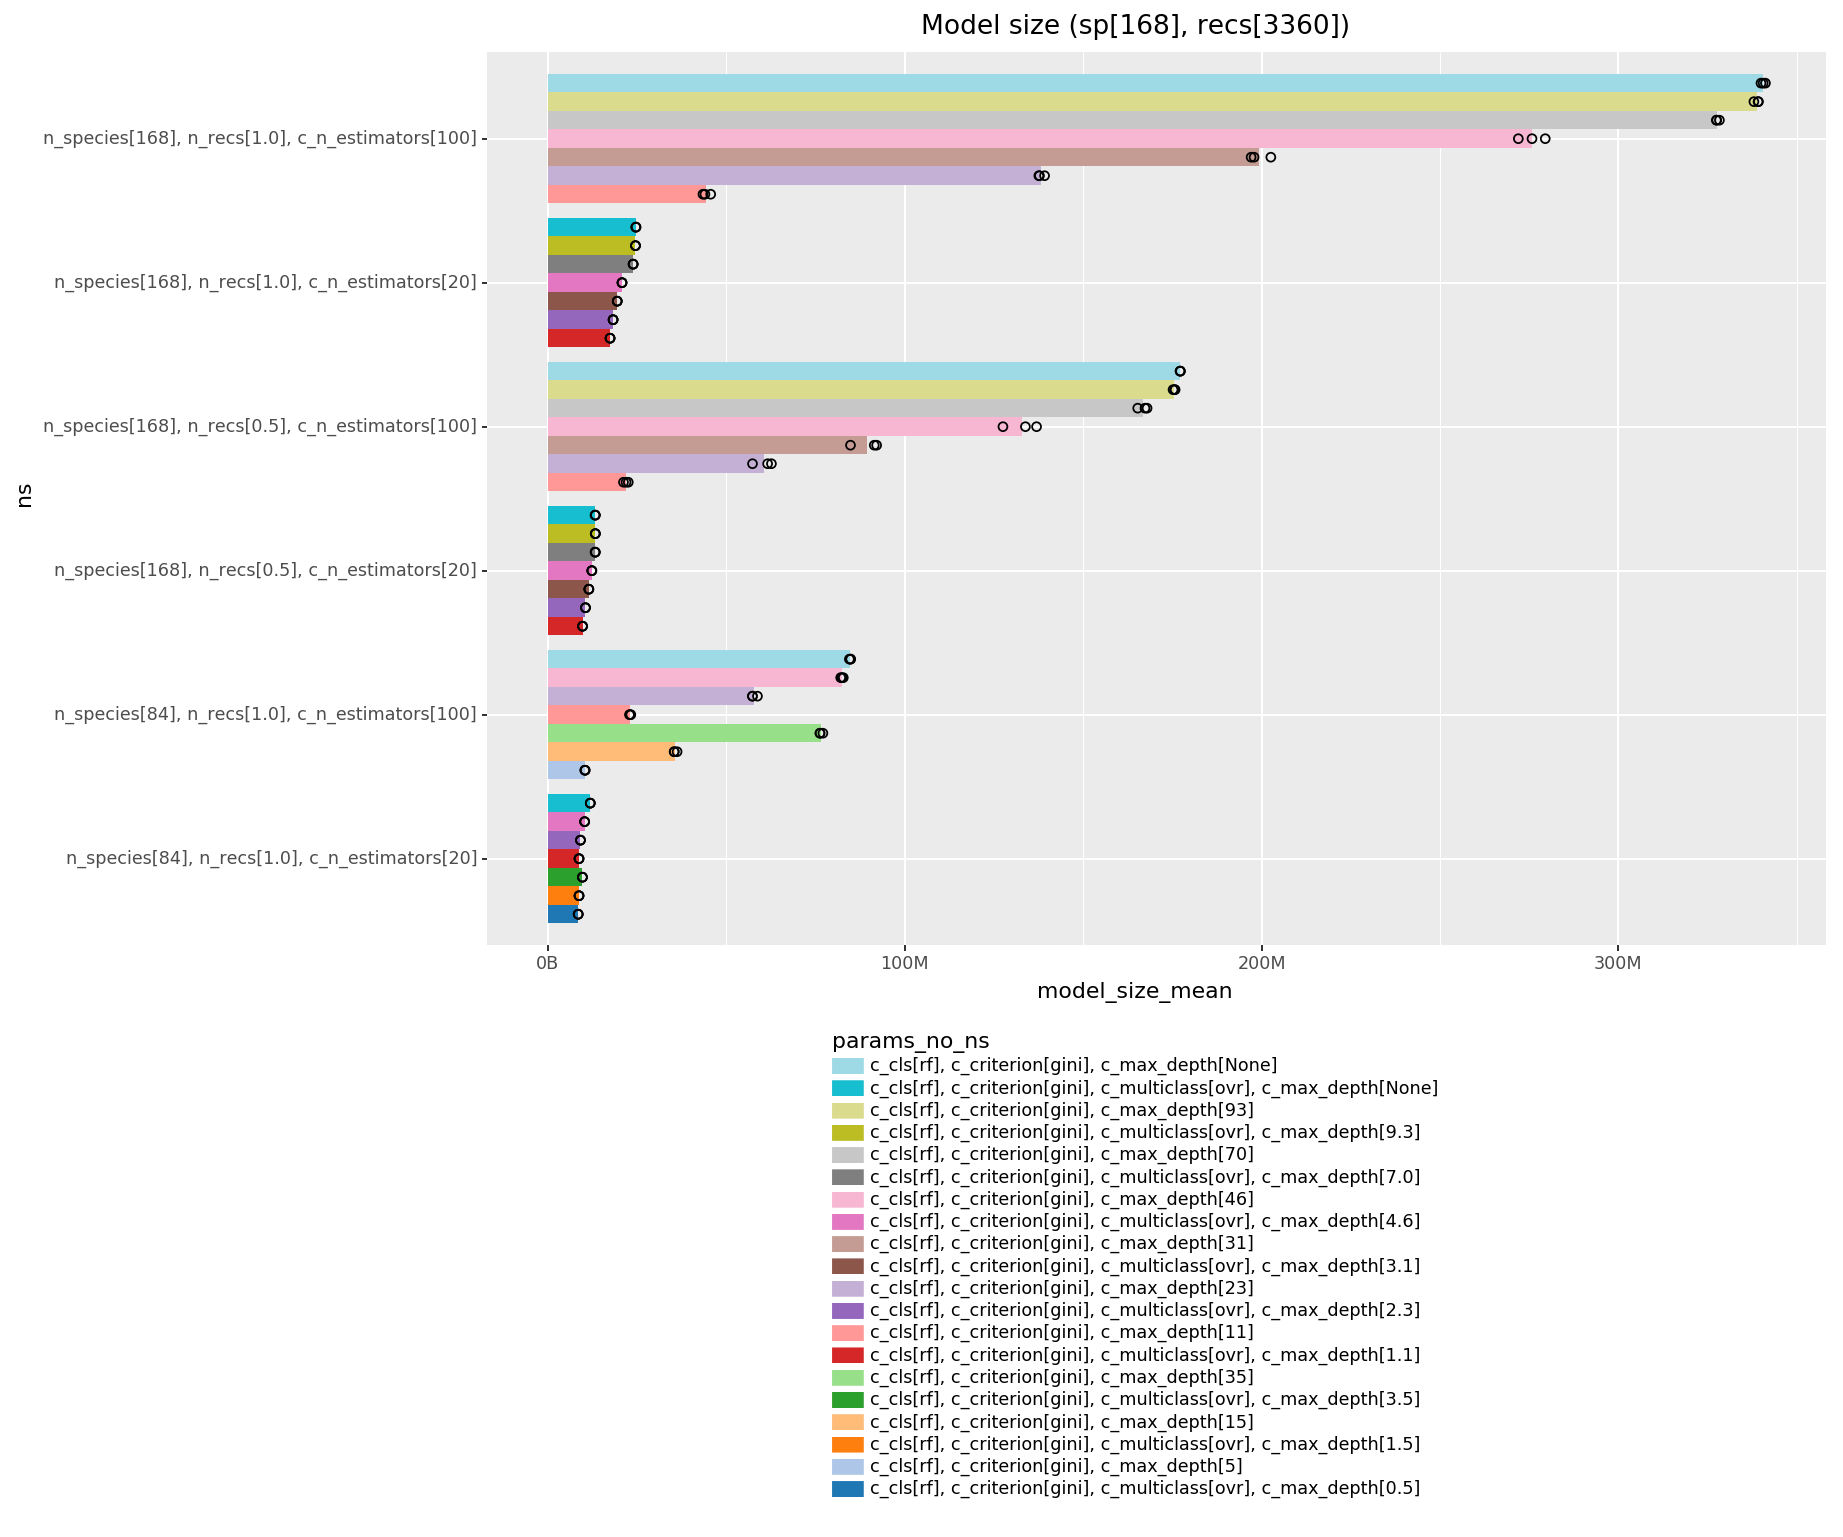

<ggplot: (337988328)>

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(model_size_mean=lambda df: df.model_size.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='model_size_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='model_size'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    # + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_fill_cmap_d(mpl.cm.tab20)
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Model size ({recs_stats})')
)

In [ ]:
# Forest depth stats so we can tune max_depth, model_size
cv_models = (cv_models
    .assign(
        # TODO Generalize this for models other than rf
        forest_depth_mean=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.mean())),
        forest_depth_std=lambda df: df.model_stats.map(lambda stats: or_else(None, lambda: stats.depth.std())),
    )
)
display(
    cv_models[['model_id', 'forest_depth_mean', 'forest_depth_std']],
)

,model_id,forest_depth_mean,forest_depth_std
0,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[0]",93.40,11.600
1,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[1]",92.70,13.100
2,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[null], fold[2]",95.00,13.400
3,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null], fold[0]",7.82,1.640
4,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null], fold[1]",7.76,1.640
5,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[null], fold[2]",7.83,1.620
6,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[93], fold[0]",88.70,6.440
7,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[93], fold[1]",87.50,7.110
8,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[100], c_max_depth[93], fold[2]",88.80,6.220
9,"n_species[168], n_recs[1.0], c_cls[rf], c_criterion[gini], c_n_estimators[20], c_multiclass[ovr], c_max_depth[9.3], fold[0]",7.59,1.270


/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_col : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


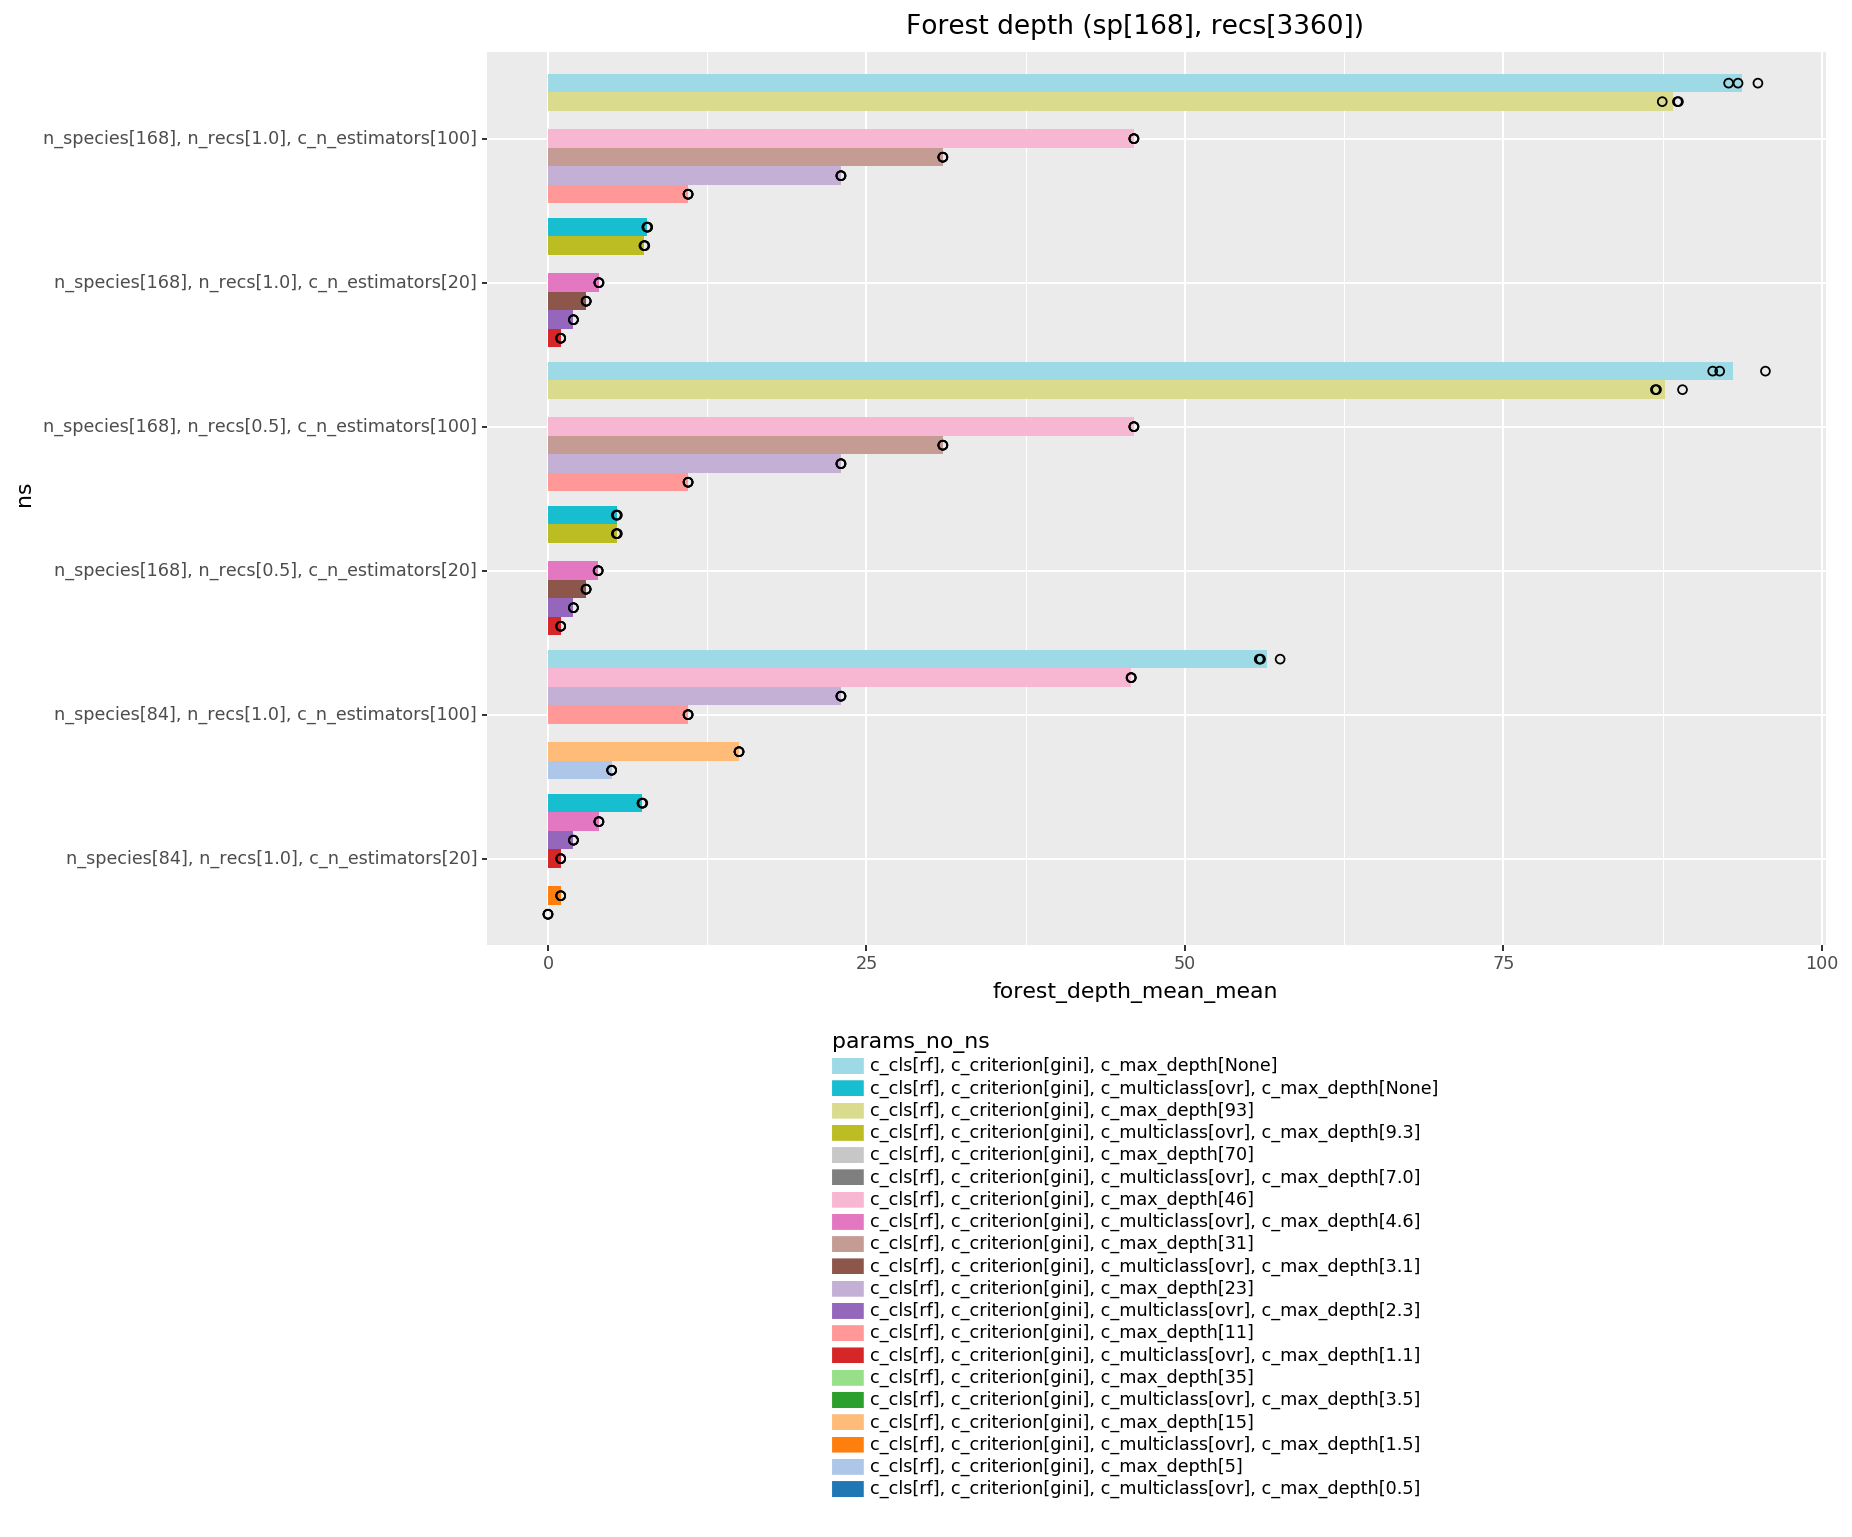

<ggplot: (-9223372036545462412)>

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(forest_depth_mean_mean=lambda df: df.forest_depth_mean.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='forest_depth_mean_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='forest_depth_mean'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    # + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_fill_cmap_d(mpl.cm.tab20)
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Forest depth ({recs_stats})')
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)
/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_pointrange : Removed 18 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


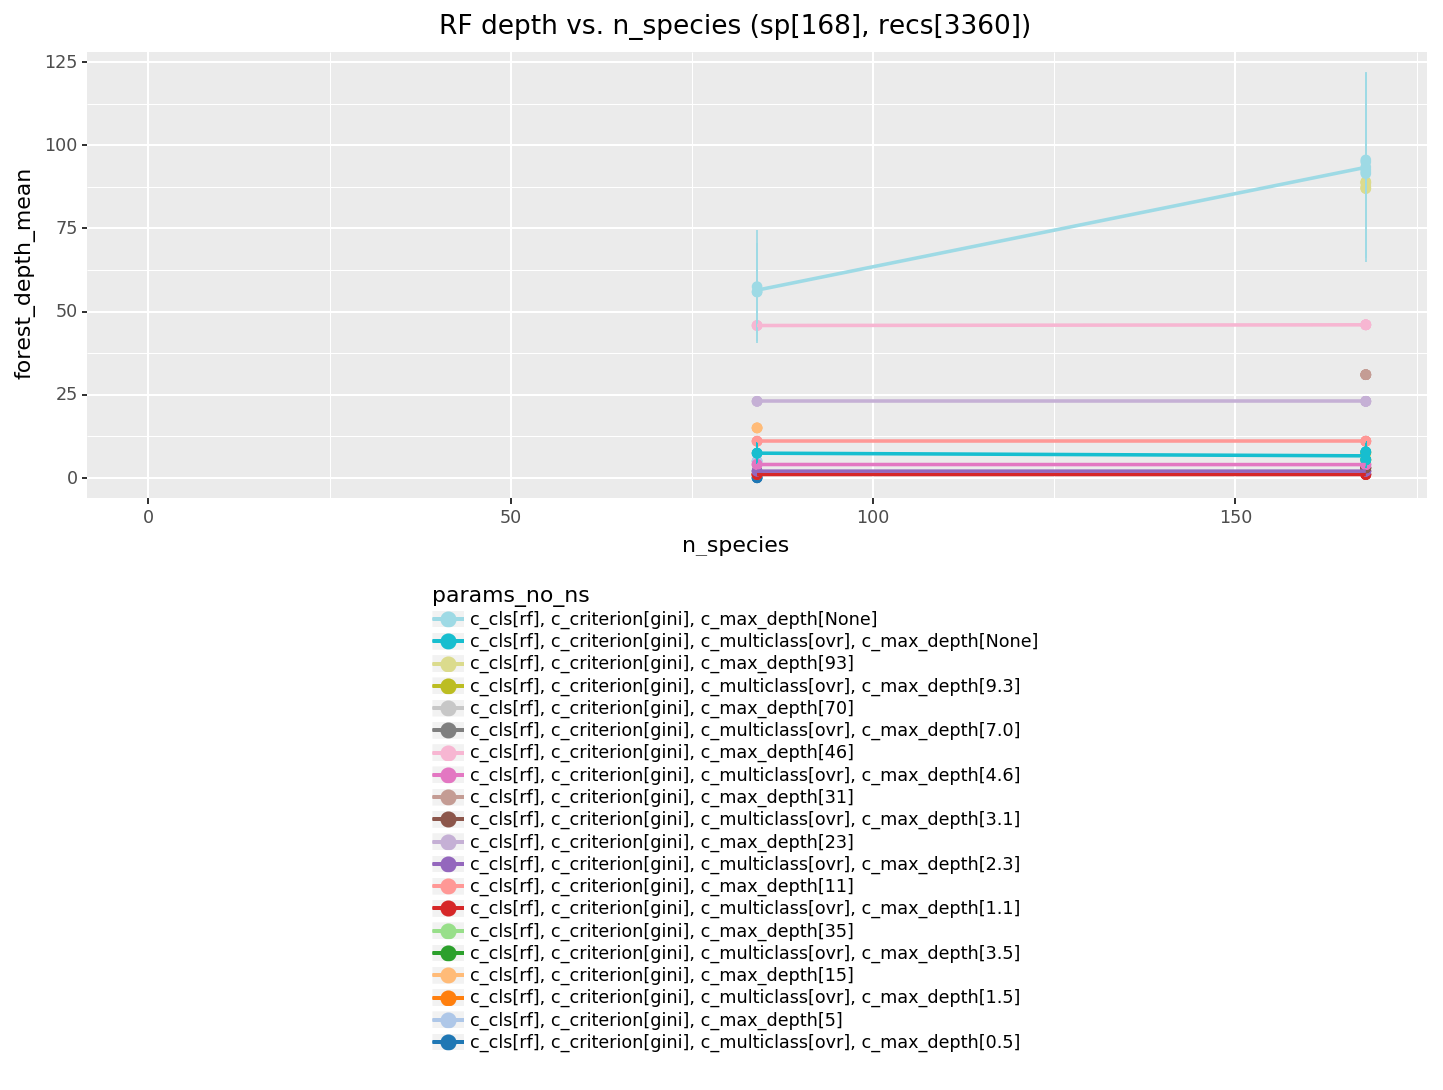

<ggplot: (351990953)>

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .assign(n_species=lambda df: df.params_dict.str['n_species'])
    .pipe(ggplot, aes(x='n_species', y='forest_depth_mean', color='params_no_ns'))
    # + facet_wrap('params_no_ns', ncol=2)
    + geom_point()
    + geom_pointrange(aes(ymin='forest_depth_mean - 2*forest_depth_std', ymax='forest_depth_mean + 2*forest_depth_std'))
    + geom_smooth(method='lm', se=False)  # Disable se because it only knows forest_depth_mean, no measure of spread
    + expand_limits(x=0)
    # + scale_color_cmap_d(mpl.cm.tab10)
    + scale_color_cmap_d(mpl.cm.tab20)
    + guides(color=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(aspect_ratio=1/3)
    + theme_figsize(aspect_ratio=1/3)
    + ggtitle(f'RF depth vs. n_species ({recs_stats})')
)

In [ ]:
(cv_models
    .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    # Manually compute y.mean() per group
    .groupby('params').apply(lambda g: g.assign(mem_rss_spread_mean=lambda df: df.mem_rss_spread.mean()))
    .pipe(ggplot, aes(x='ns', group='params_no_ns'))
    + geom_col(aes(y='mem_rss_spread_mean', fill='params_no_ns'), position=position_dodge()) # Summary per fold
    + geom_point(aes(y='mem_rss_spread'), fill='none', size=2, position=position_dodge(width=.9)) # Distribution of folds
    + coord_flip()
    # + scale_fill_cmap_d(mpl.cm.tab10)
    + scale_fill_cmap_d(mpl.cm.tab20)
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/3*2)
    + ggtitle(f'Mem rss spread ($max-min$) ({recs_stats})')
)

[skip]

In [ ]:
# TODO Might need to stack/geom_area for overlapping runs
(cv_models_proc_stats
    .pipe(ggplot, aes(x='time',
        color='model_id',
        # color='params_no_ns', linetype='ns',
        # color='params_no_ns', size='ns',
    ))
    + geom_line(aes(y='cpu_system'), linetype='dashed', size=.5)
    + geom_line(aes(y='cpu_system + cpu_user'), linetype='solid', size=.5)
    # + geom_line(aes(y='cpu_system + cpu_user'), size=1)
    + expand_limits(y=0)
    + ylab('cpu')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=lambda labels: ['%.3g%%' % x for x in labels])
    # + scale_color_cmap_d(mpl.cm.tab20)
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('cpu over time (system + user)')
)

[skip]

In [ ]:
(cv_models_proc_stats
    .pipe(ggplot, aes(x='time', color='model_id'))
    + geom_line(aes(y='mem_rss'), linetype='solid', size=.5)
    + geom_line(aes(y='mem_vms'), linetype='dashed', size=.5)
    + expand_limits(y=0)
    + ylab('mem')
    + scale_x_datetime(date_labels='%H:%M:%S')
    + scale_y_continuous(labels=labels_bytes(), breaks=breaks_bytes(pow=3))
    # + scale_color_cmap_d(mpl.cm.tab20)
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize('inline_short')
    + ggtitle('Mem over time (rss, vms)')
)

[skip]

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/guides/guides.py:200: UserWarning: Cannot generate legend for the 'shape' aesthetic. Make sure you have mapped a variable to it
  "variable to it".format(output))


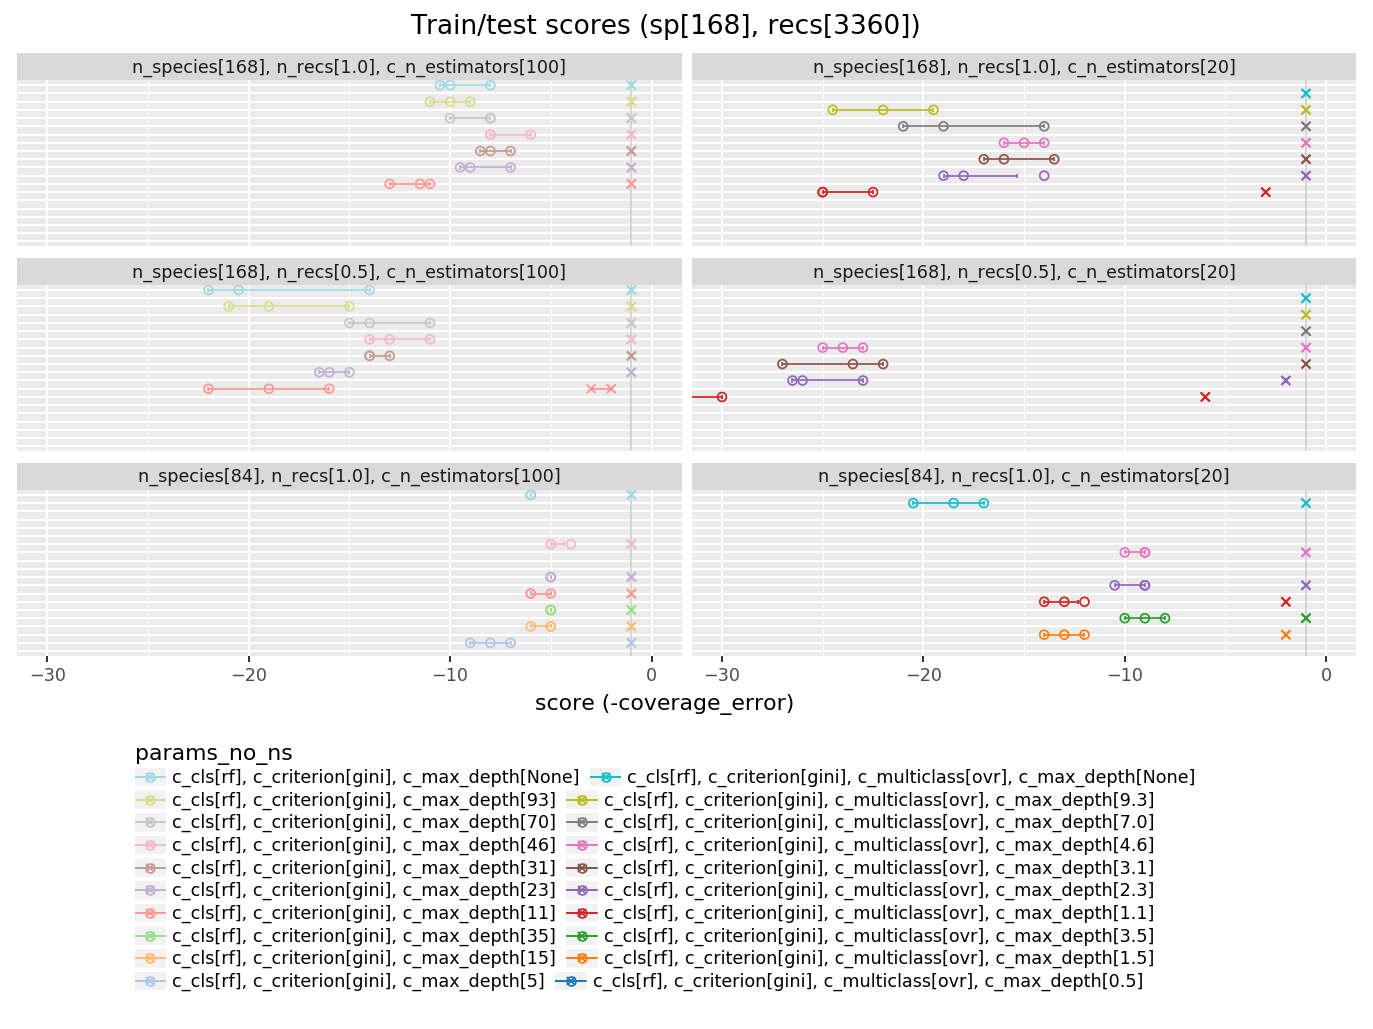

<ggplot: (-9223372036541702652)>

In [ ]:
# Train/test scores
#   - Grain: models x {train,test}
#   - Metrics: score
#   - Dims: group, params
(cv_models
    .pipe(df_reverse_cat, 'params_no_ns')
    .pipe(lambda df: pd.melt(
        df,
        id_vars=['ns', 'params_no_ns', 'params', 'fold'],
        value_vars=['train_score', 'test_score'],
        var_name='split',
        value_name='score'),
    )
    .assign(
        split=lambda df: df.split.str.replace('_score', ''),
        group=lambda df: df.params_no_ns.str.cat(df.split, '/'),
    )
    .pipe(df_ordered_cat,
        group=lambda df: reversed(df.group.unique()),
    )
    .pipe(lambda df: (df
        .pipe(ggplot, aes(
            x='params_no_ns',
            y='score',
            # color='group',  # Ran out of colors
            color='params_no_ns',
        ))
        + facet_wrap('ns', ncol=2)
        + geom_hline(yintercept=-1, color='lightgrey')  # -1 is the max score (1 is the min coverage_error)
        + geom_point(data=df[df.split == 'test'], shape='o', fill='none', size=2)
        + geom_point(data=df[df.split == 'train'], shape='x', size=2)
        # + geom_line(aes(group='str(group) + str(fold)'), alpha=.2)  # More trouble than it's worth
        + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='errorbar')
        # + stat_summary(aes(group='group'), fun_data='mean_cl_boot', random_state=0, geom='line', size=1)  # More trouble than it's worth
        # + scale_color_cmap_d(mpl.cm.tab10)
        + scale_color_cmap_d(mpl.cm.tab20)
        + coord_flip(
            ylim=(-30, 0),
        )
        + scale_shape_manual(values=['o', 'x'])
        + guides(color=guide_legend(reverse=True, ncol=2, byrow=True))
        + theme(axis_title_y=element_blank(), axis_text_y=element_blank(), axis_ticks_major_y=element_blank())
        + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
        + theme_figsize(width=12, aspect_ratio=1/4)
        + ylab('score (-coverage_error)')
        + ggtitle(f'Train/test scores ({recs_stats})')
    ))
)

/Users/danb/miniconda3/envs/bubo-features/lib/python3.6/site-packages/plotnine/layer.py:452: UserWarning: geom_point : Removed 17 rows containing missing values.
  self.data = self.geom.handle_na(self.data)


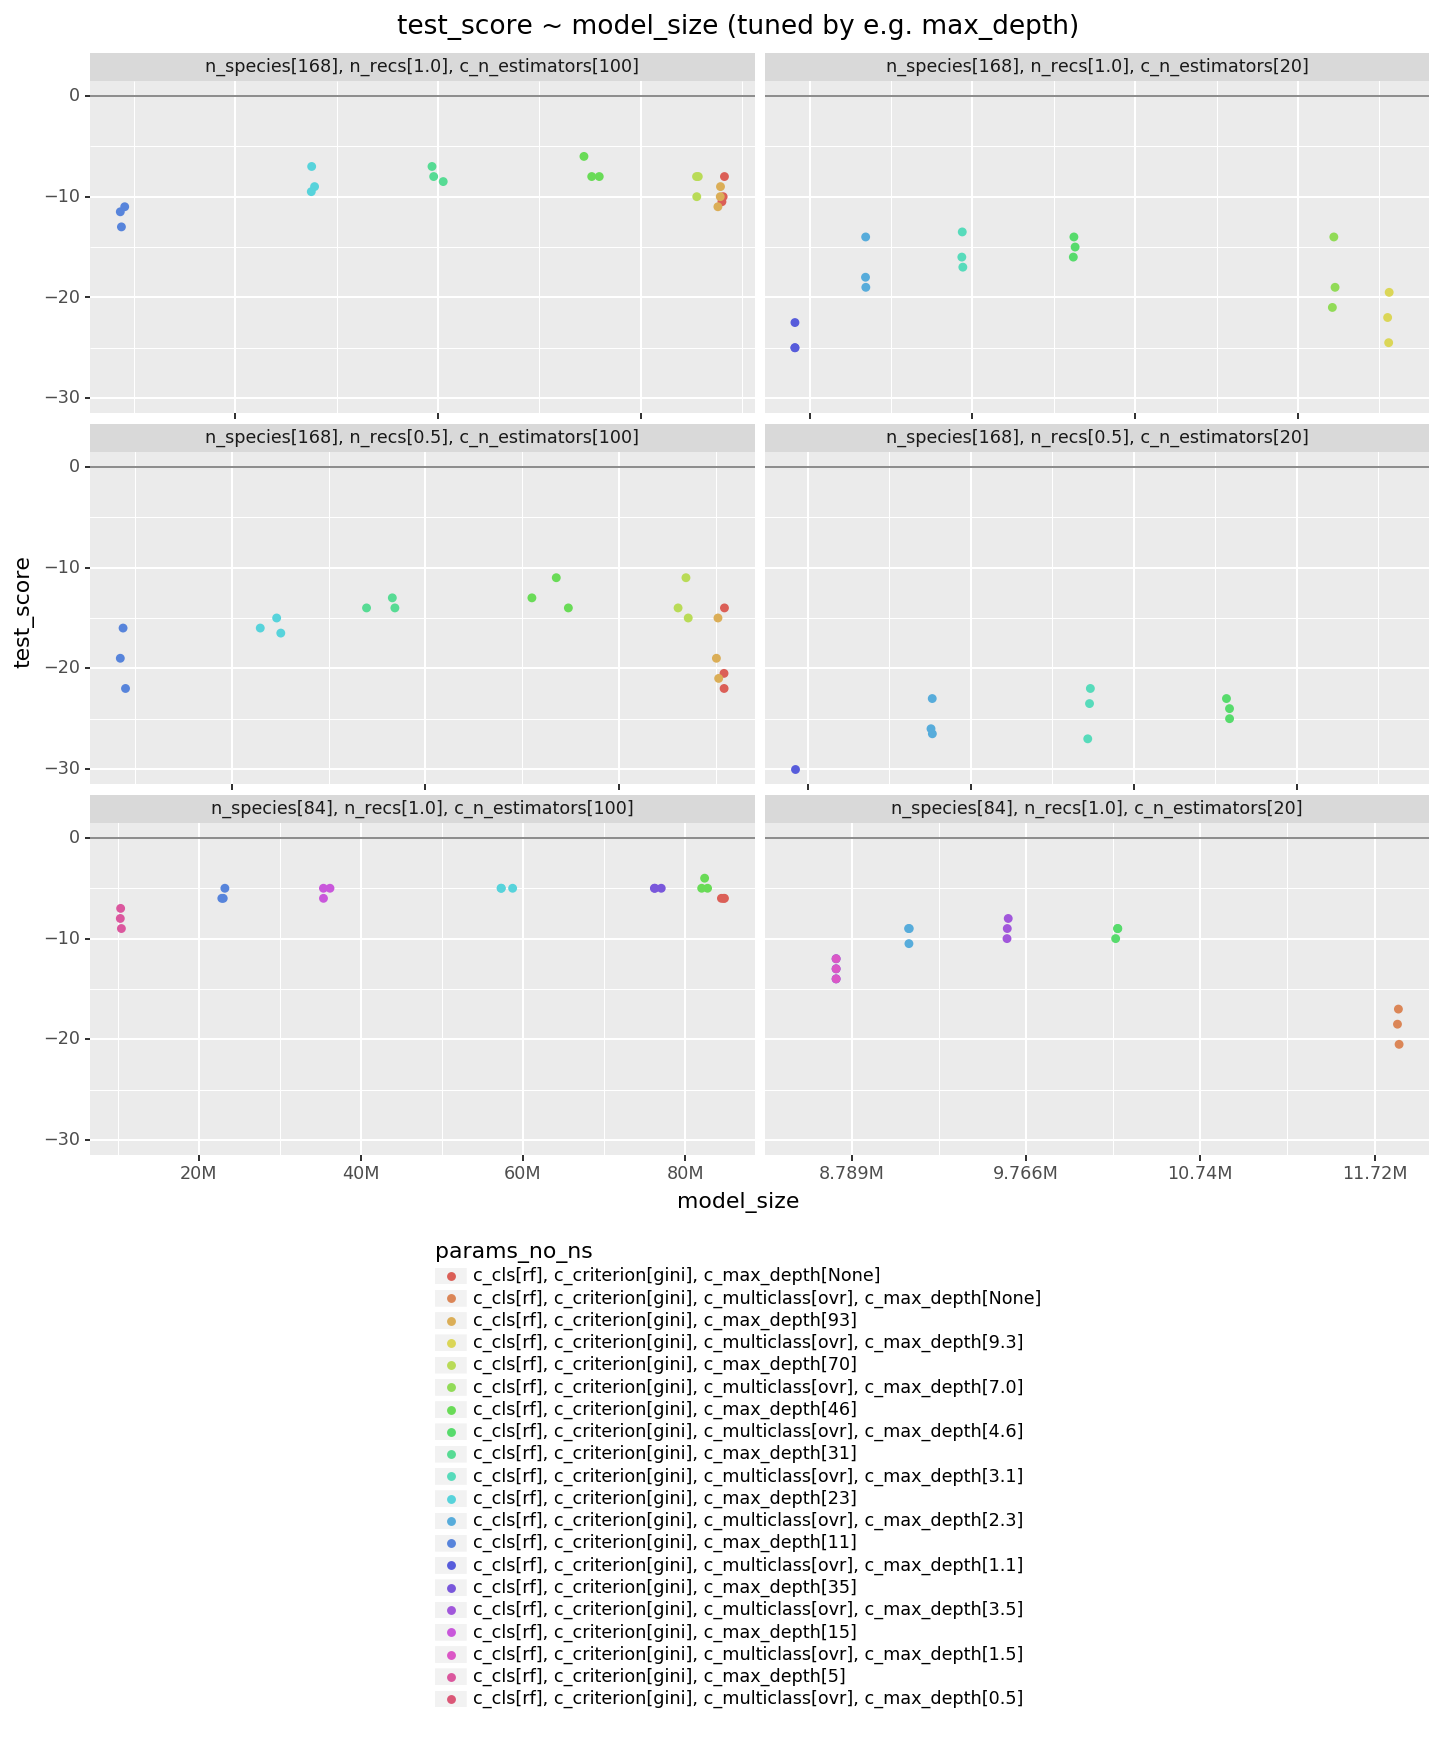

<ggplot: (312821789)>

In [ ]:
(cv_models
    .pipe(ggplot, aes(x='model_size', y='test_score'))
    + aes(color='params_no_ns') + facet_wrap('ns', ncol=2,
        scales='free_x',
    )
    + geom_point()
    + geom_hline(yintercept=0, color='grey')
    + scale_x_continuous(labels=labels_bytes(), breaks=breaks_bytes())
    + ylim(-30, 0)
    + guides(fill=guide_legend(reverse=True))
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    + theme_figsize(aspect_ratio=1/2)
    + ggtitle('test_score ~ model_size (tuned by e.g. max_depth)')
)

In [ ]:
STOP

NameError: name 'STOP' is not defined

# Model diagnostics: all models, all folds

In [ ]:
print('models:')
print('  params[*/%s]' % len(cv_models.params.cat.categories))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# TODO Cache
# Coverage errors: all models, all folds
#   - Subset: all models
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_all_all = (cv_models
    # .sample(n=5, random_state=0)  # For faster dev
    .pipe(lambda df: DF(
        OrderedDict(
            # **row[['model_id', 'params', 'fold']],  # Slow (in this inner loop), unpack manually instead
            model_id=row.model_id,
            params=row.params,
            params_no_ns=row.params_no_ns,
            ns=row.ns,
            fold=row.fold,
            i=i,
            y_true=y_true,
            coverage_error=coverage_error,
        )
        for row in iter_progress(df_rows(df), n=len(df))
        for i, y_true, coverage_error in zip(
            row.test_evals.i,
            row.test_evals.y,
            row.test_evals.coverage_errors(),
        )
    ))
    .astype(dict(
        model_id=cv_models.model_id.dtype,
        params=cv_models.params.dtype,
        params_no_ns=cv_models.params_no_ns.dtype,
        ns=cv_models.ns.dtype,
    ))
    .pipe(tap, lambda df: display(
        df_summary(df).T,
        df[:10],
    ))
)

In [ ]:
# Facet by params_no_ns, order by median(coverage_error)
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .pipe(df_reverse_cat, 'params', 'params_no_ns', 'ns')
    .pipe(df_ordered_cat,
        y_true=lambda df: (
            # Sort species by median(coverage_error) (across all models)
            df.groupby('y_true').agg({'coverage_error': np.median}).reset_index().sort_values('coverage_error').y_true
            # Sort species by taxo (hard to compare across models, unless they're pretty low noise)
            # reversed(recs.species.cat.categories)
        ),
    )
    .pipe(ggplot, aes(x='y_true', y='coverage_error',
        # color='params',
    ))
    # + facet_wrap('params_no_ns', ncol=3)
    + facet_grid('ns ~ params_no_ns')
    # + geom_line(aes(group='params'), stat='summary', fun_y=np.median)  # TODO Bad interpolation with n_species
    + geom_point(aes(group='params'), stat='summary', fun_y=np.median)
    + coord_flip(
        # ylim=(0, min(30, len(np.unique(y)))),  # Restore eventually
    )
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')
    # + scale_color_cmap_d(mpl.cm.tab20)
    + theme(legend_position='bottom', legend_direction='vertical', legend_box_spacing=.4, legend_key_height=8)
    # + theme_figsize(width=12*2, aspect_ratio=2/3)
    + theme_figsize(width=12, aspect_ratio=1/4)
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params_no_ns $\times$ ns ({recs_stats})')
)

In [ ]:
# TODO Slow, bad for notebook dev loop -- move lower, or disable by default?
# Facet by species
#   - Subset: all models
#   - Grain: sum(recs[model.test_i].groupby(params, y_true) for model)
#       - Over: fold, rec_id
#   - Dims: params, y_true
#   - Metrics: coverage_error.median
# in: coverage_errors_all_all, recs
(coverage_errors_all_all
    # .sample(200, random_state=0)  # Faster dev
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'params')
    .pipe(ggplot, aes(x='params', y='coverage_error', color='params_no_ns'))
    + facet_wrap('y_true')
    + geom_hline(yintercept=1, color='grey')
    # + geom_hline(yintercept=recs.species.nunique(), color='grey')

    # Percentiles (faster, no overplot)
    # + geom_point(stat='summary', fun_y=np.median)
    # + geom_linerange(stat='summary', fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75))

    # Violin (slow, no overplot)
    # + geom_violin()

    # Boxplot (very slow, no overplot)
    # + geom_boxplot()

    # Points (medium cost, high overplot)
    #   - n (count) instead of prop (proportion)
    #   - scale_size_area() instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_count(aes(size='..n..'), alpha=.5)
    + scale_size_area()
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='black', shape='|', size=3, stroke=1)

    + coord_flip()
    + scale_color_cmap_d(mpl.cm.tab20)
    + theme(axis_text_y=element_text(size=6))
    + theme_figsize('square')  # Faster
    # + theme_figsize('half')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance, by params ({recs_stats})')
)

# Model diagnostics: one model, all folds

In [ ]:
params_i = 0
params = cv_models.params.cat.categories[params_i]
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('models:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), params))
print('  fold[*/%s]' % cv.cv.n_splits)

In [ ]:
# Coverage errors: one model, all folds
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i] for model)
#   - Dims: model_id, params, fold, y_true, rec_id
#   - Metrics: coverage_error
coverage_errors_one_all = (coverage_errors_all_all
    [lambda df: df.params == params]  # One model, all folds
)
display(
    df_summary(coverage_errors_one_all).T,
    coverage_errors_one_all[:10],
)

In [ ]:
#   - Subset: models.params == params
#   - Grain: sum(recs[model.test_i].groupby(y_true) for model)
#       - Over: fold, rec_id
#   - Dims: y_true
#   - Metrics: count, coverage_error.percentiles
# in: coverage_errors_one_all, recs
(coverage_errors_one_all
    .astype({'y_true': metadata.species.df.shorthand.dtype})
    .pipe(df_reverse_cat, 'y_true')
    .pipe(ggplot, aes(x='y_true', y='coverage_error'))
    + geom_hline(yintercept=1, color='grey')
    + geom_hline(yintercept=recs.species.nunique(), color='grey')
    + geom_count(aes(size='..n..'), alpha=1)  # n (count) instead of prop (proportion)
    + scale_size_area()  # Instead of default scale_size(), because it's a count [I don't grok this but it looks good]
    + geom_point(stat='summary', fun_y=np.median, alpha=1, color='red', shape='|', size=6, stroke=2)
    + coord_flip()
    # + theme_figsize('inline')
    # + theme_figsize('square')
    # + theme_figsize('half')
    + theme_figsize('half_dense')
    # + theme_figsize('full')
    # + theme_figsize('full_dense')
    + ggtitle(rf'Coverage error over fold $\times$ instance ({params}) ({recs_stats})')
)

In [ ]:
# One-model/all-folds confusion matrix
with figsize(
    # 'square',
    # 'full',
    'full_dense',
):
    (cv_models
        [lambda df: df.params == params]
        .pipe(lambda df: plot_confusion_matrix(
            classes=df.iloc[0].test_evals.classes,
            M=np.array([
                row.test_evals.confusion_matrix_prob()
                for row in df_rows(df)
            ]).sum(axis=0),
            # normalize=False,  # For counts
            raw=True, scale=10,  # Faster dev
            format=None,  # Omit numbers, too dense
            title=f'({recs_stats})',
        ))
    )

# Model diagnostics: one model, one fold

In [ ]:
fold = 0
# params_i = ...  # Comment out to reuse from above
params = cv_models.params.cat.categories[params_i]
[(_, model)] = list(cv_models[lambda df: (df.params == params) & (df.fold == fold)].iterrows())
print("params:\n%s" % '\n'.join('  %s: %r' % (i, x) for i, x in enumerate(cv_models.params.cat.categories)))
print()
print('model:')
print('  params[%s/%s]: %r' % (params_i, len(cv_models.params.cat.categories), model.params))
print('  fold[%s/%s]' % (model.fold, cv.cv.n_splits))
print()
print(model)

[skip]

In [ ]:
# in: model
model_id = model.model_id
params = model.params
fold = model.fold
# train_evals = model.train_evals
test_evals = model.test_evals

# in: model, recs
# train_recs = recs.iloc[train_evals.i]
# train_X = Search.X(recs)[train_evals.i]
# train_y = Search.y(recs)[train_evals.i]
test_recs = recs.iloc[test_evals.i]
test_X = Search.X(recs)[test_evals.i]
test_y = Search.y(recs)[test_evals.i]  # (Don't need to store cv_models.test_evals.y if we have recs -- which sometimes we don't?)

display(
    # len(train_recs),
    len(test_recs),
)

[skip]

In [ ]:
# TODO Restore this plot like 'Coverage error over ...' above, so we can see _one_ model instead of aggregating over n_splits models
# # TODO Update [kill the .merge, then species -> y_true]
# (search.coverage_error_by(test_recs, 'id')
#     [:5]
#     # .merge(test_recs[['id', 'species']], on='id', how='left')
#     # .pipe(ggplot, aes(x='species', y='coverage_error'))
#     # + geom_count(aes(size='..n..'))
#     # + stat_summary(fun_y=np.median, geom='point', color='red', alpha=.5, shape='|', size=6, stroke=1)
#     # + stat_summary(
#     #     fun_ymin=partial(np.percentile, q=25), fun_ymax=partial(np.percentile, q=75),
#     #     geom='linerange', color='red', alpha=.5, size=1,
#     # )
#     # + coord_flip()
#     # + geom_hline(yintercept=len(search.classes_), color='grey')
#     # + scale_x_discrete(limits=list(reversed(test_recs.species.cat.categories)))
#     # + theme_figsize('square')
#     # + ggtitle(rf'Coverage error over instance ({model_id}) ({recs_stats})')
# )

[skip]

In [ ]:
# One-model/one-fold confusion matrix
with figsize(
    'square',
    # 'full',
    # 'full_dense',
):
    plot_confusion_matrix_df(
        confusion_matrix_prob_df(model.test_evals.y, model.test_evals.y_scores, model.test_evals.classes),
        title=model.model_id,
        # normalize=False,  # For counts
        raw=True, scale=10,  # Faster dev
        title=f'({recs_stats})',
    )

[skip]